In [ ]:
%matplotlib inline


# Simulating PV system DC output using the ADR module efficiency model

Time series processing with the ADR model is really easy.

This example reads a TMY3 weather file, and runs a basic simulation
on a fixed latitude-tilt system.
Efficiency is independent of system size, so adjusting the system
capacity is just a matter of setting the desired value, e.g. P_STC = 5000.




In [ ]:
import os
import pandas as pd
import matplotlib.pyplot as plt

import pvlib
from pvlib import iotools, location
from pvlib.irradiance import get_total_irradiance
from pvlib.pvarray import pvefficiency_adr
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import plotly
import plotly.graph_objs as go

#init_notebook_mode(connected=True)

Read a TMY3 file containing weather data and select needed columns




In [26]:
#PVLIB_DIR = pvlib.__path__[0]
#DATA_FILE = os.path.join(PVLIB_DIR, 'data', '723170TYA.CSV')
DATA_FILE= ('/home/pavel/PycharmProjects/nydrogen/data/psp_pv_2015.csv')
#tmy, metadata = iotools.read_tmy3(DATA_FILE, coerce_year=1990)
tmy=pd.read_csv(DATA_FILE)

print(tmy.columns.values)
tmy['DATE']=pd.to_datetime(tmy[['Year','Month','Day','Hour','Minute']])
df = pd.DataFrame({'ghi': tmy['GHI'], 'dhi': tmy['DHI'], 'dni': tmy['DNI'],
                   'temp_air': tmy['Temperature'], 'wind_speed': tmy['Wind Speed'],
                   'date':tmy['DATE']})

df.head(10)
#df['DATE']= pd.to_datetime()

['Year' 'Month' 'Day' 'Hour' 'Minute' 'DHI' 'DNI' 'Temperature' 'GHI'
 'Clearsky DHI' 'Clearsky DNI' 'Clearsky GHI' 'Wind Speed']


,ghi,dhi,dni,temp_air,wind_speed,date
0,0,0,0,2,1.9,2015-01-01 00:30:00
1,0,0,0,1,1.9,2015-01-01 01:30:00
2,0,0,0,1,1.9,2015-01-01 02:30:00
3,0,0,0,1,1.9,2015-01-01 03:30:00
4,0,0,0,1,2.0,2015-01-01 04:30:00
5,0,0,0,2,1.9,2015-01-01 05:30:00
6,0,0,0,2,2.0,2015-01-01 06:30:00
7,84,34,465,5,2.6,2015-01-01 07:30:00
8,270,68,735,8,3.4,2015-01-01 08:30:00
9,437,87,852,10,3.8,2015-01-01 09:30:00


Shift timestamps to middle of hour and then calculate sun positions

Формат файла в данный момент другой предусмотреть разбивку на 2 csv


In [27]:
df.index = df.date - pd.Timedelta(minutes=30)
metadata= {'USAF': 81257, 'Name': '"Palm Springs"', 'State': 'NC', 'TZ': -5.0, 'latitude': 33.81, 'longitude': -116.54, 'altitude': 164.0}
loc = location.Location.from_tmy(metadata)
#print(loc)
solpos = loc.get_solarposition(df.index)
print(solpos)

                     apparent_zenith      zenith  apparent_elevation  \
date                                                                   
2015-01-01 00:00:00        82.227955   82.339523            7.772045   
2015-01-01 01:00:00        93.116052   93.116052           -3.116052   
2015-01-01 02:00:00       104.664368  104.664368          -14.664368   
2015-01-01 03:00:00       116.714815  116.714815          -26.714815   
2015-01-01 04:00:00       129.062100  129.062100          -39.062100   
...                              ...         ...                 ...   
2015-12-31 19:00:00        58.049761   58.076133           31.950239   
2015-12-31 20:00:00        56.917090   56.942348           33.082910   
2015-12-31 21:00:00        59.297252   59.324933           30.702748   
2015-12-31 22:00:00        64.798383   64.833192           25.201617   
2015-12-31 23:00:00        72.698964   72.750974           17.301036   

                     elevation     azimuth  equation_of_time  


Determine  total irradiance on a fixed-tilt array




In [28]:
TILT = 33.81
print(TILT)
ORIENT = 180

total_irrad = get_total_irradiance(TILT, ORIENT,
                                   solpos.apparent_zenith, solpos.azimuth,
                                   df.dni, df.ghi, df.dhi)

df['poa_global'] = total_irrad.poa_global
print(df['poa_global'])

33.81
date
2015-01-01 00:00:00    0.0
2015-01-01 01:00:00    0.0
2015-01-01 02:00:00    0.0
2015-01-01 03:00:00    0.0
2015-01-01 04:00:00    0.0
                      ... 
2015-12-31 19:00:00    0.0
2015-12-31 20:00:00    0.0
2015-12-31 21:00:00    0.0
2015-12-31 22:00:00    0.0
2015-12-31 23:00:00    0.0
Name: poa_global, Length: 8760, dtype: float64


Estimate the expected operating temperature of the PV modules




In [29]:
df['temp_pv'] = pvlib.temperature.faiman(df.poa_global, df.temp_air,
                                         df.wind_speed)
print(df['temp_pv'])

date
2015-01-01 00:00:00    2.0
2015-01-01 01:00:00    1.0
2015-01-01 02:00:00    1.0
2015-01-01 03:00:00    1.0
2015-01-01 04:00:00    1.0
                      ... 
2015-12-31 19:00:00    3.0
2015-12-31 20:00:00    2.0
2015-12-31 21:00:00    2.0
2015-12-31 22:00:00    2.0
2015-12-31 23:00:00    2.0
Name: temp_pv, Length: 8760, dtype: float64


Now we're ready to calculate PV array DC output power based
on POA irradiance and PV module operating temperature.
Among the models available in pvlib-python to do this are:

 - PVWatts
 - SAPM
 - single-diode model variations

And now also the ADR PV efficiency model

Simulation is done in two steps:

 - first calculate efficiency using the ADR model,
 - then convert (scale up) efficiency to power.




In [30]:
# Borrow the ADR model parameters from the other example:

adr_params = {'k_a': 0.99924,
              'k_d': -5.49097,
              'tc_d': 0.01918,
              'k_rs': 0.06999,
              'k_rsh': 0.26144
              }

df['eta_rel'] = pvefficiency_adr(df['poa_global'], df['temp_pv'], **adr_params)

# Set the desired array size:
P_STC = 5000.   # (W)

# and the irradiance level needed to achieve this output:
G_STC = 1000.   # (W/m2)

df['p_mp'] = P_STC * df['eta_rel'] * (df['poa_global'] / G_STC)

Show how power and efficiency vary with both irradiance and temperature




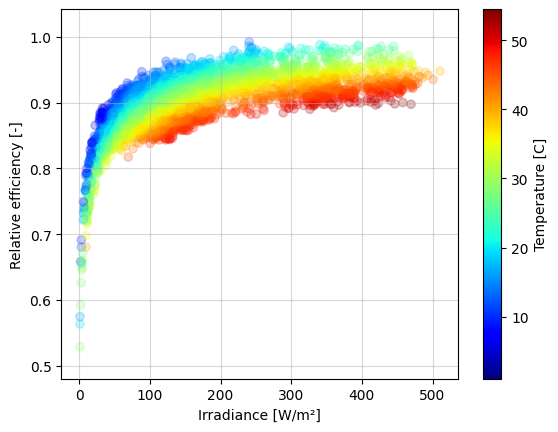

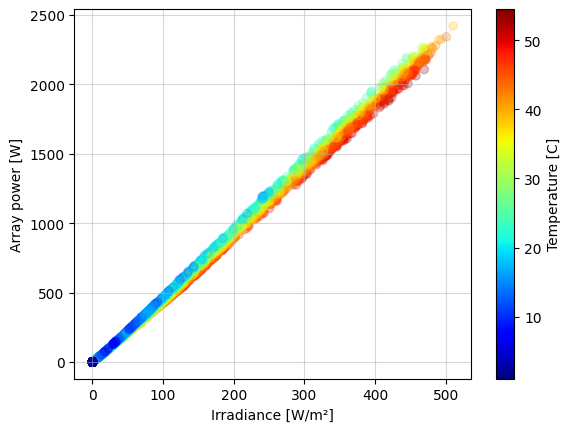

In [31]:
plt.figure()
pc = plt.scatter(df['poa_global'], df['eta_rel'], c=df['temp_pv'], cmap='jet')
plt.colorbar(label='Temperature [C]', ax=plt.gca())
pc.set_alpha(0.25)
plt.grid(alpha=0.5)
plt.ylim(0.48)
plt.xlabel('Irradiance [W/m²]')
plt.ylabel('Relative efficiency [-]')
plt.show()

plt.figure()
pc = plt.scatter(df['poa_global'], df['p_mp'], c=df['temp_pv'], cmap='jet')
plt.colorbar(label='Temperature [C]', ax=plt.gca())
pc.set_alpha(0.25)
plt.grid(alpha=0.5)
plt.xlabel('Irradiance [W/m²]')
plt.ylabel('Array power [W]')
plt.show()

One day:




In [32]:
DEMO_DAY = '2015-08-05'
trace0= go.Scatter(
    x=df.index,
    y=df['p_mp'][DEMO_DAY]
)


day_fig = go.Figure(data=[trace0],
                layout={'title': 'quantity of hydrogen produced by day', 'xaxis_title':"Hour",'yaxis_title':"Power [W]"})
iplot(day_fig, show_link=False)



Month

In [39]:
DEMO_MONTH = 1
df['month'] = pd.DatetimeIndex(df['date']).month
df['day'] = pd.DatetimeIndex(df['date']).day
month_df=df.loc[df['month'] ==DEMO_MONTH]

month_df=month_df.groupby(['day'])['p_mp'].agg('sum')
print(month_df)
trace1 = go.Scatter(
    x=month_df.index,
    y=month_df
)


month_fig = go.Figure(data=[trace1], layout=
{'title': 'quantity of hydrogen produced by Month', 'xaxis_title':"DAY",'yaxis_title':"Power [W]"})
iplot(month_fig, show_link=False)

day
1     5244.991092
2     5181.824429
3     4408.370483
4     4636.770332
5     3450.651790
6     4422.535380
7     6334.493026
8     6090.054920
9     5503.876050
10    7047.974302
11    3356.794382
12    7567.066903
13    4858.249550
14    4773.256423
15    5175.914894
16    5530.071896
17    4705.456248
18    6164.239734
19    6193.127525
20    6897.094888
21    5049.785705
22    6230.434349
23    5080.687480
24    5025.081710
25    5509.633911
26    2812.902978
27    6091.009233
28    6925.882069
29    7243.331452
30    6431.106745
31    8463.411208
Name: p_mp, dtype: float64


Year



In [34]:
year_df=df.groupby(['month'])['p_mp'].agg('sum') #0.05

trace2 = go.Scatter(
    x=year_df.index,
    y=year_df
)


year_fig = go.Figure(data=trace2, layout={'title': 'quantity of hydrogen produced by year', 'xaxis_title':"Month",'yaxis_title':"Power [W]"})
iplot(year_fig, show_link=False)

Creation of consumption profile

Read df and filter by distance

In [40]:
airport_df= pd.read_csv('/home/pavel/PycharmProjects/nydrogen/data/psp_flights_2015.csv')
airport_df['DATE']=pd.to_datetime(airport_df[['YEAR','MONTH','DAY']])
airport_df=airport_df.loc[(airport_df['DISTANCE'] <200) & (airport_df['ORIGIN_AIRPORT']=='PSP')]
airport_df.head


<bound method NDFrame.head of      YEAR  MONTH  DAY  DAY_OF_WEEK AIRLINE  FLIGHT_NUMBER TAIL_NUMBER  \
0    2015      1    1            4      OO           6338      N578SW   
1    2015      1    1            4      OO           6312      N562SW   
2    2015      1    1            4      OO           6429      N586SW   
3    2015      1    1            4      OO           6302      N568SW   
4    2015      1    1            4      OO           6445      N569SW   
..    ...    ...  ...          ...     ...            ...         ...   
724  2015     12   27            7      OO           6312      N976SW   
725  2015     12   28            1      OO           6312      N912SW   
726  2015     12   29            2      OO           6312      N963SW   
727  2015     12   30            3      OO           6312      N982SW   
728  2015     12   31            4      OO           6312      N926SW   

    ORIGIN_AIRPORT DESTINATION_AIRPORT  SCHEDULED_DEPARTURE  ...  \
0              PSP       

DAY

In [37]:
DEMO_DAY = '2015-01-01'
graph_df1=airport_df.loc[airport_df['DATE'] ==DEMO_DAY]
graph_df1=graph_df1.groupby(['DATE'])['DISTANCE'].agg('sum')#/1.55 1 кг - 33.3 кв т
print(graph_df1)
trace_air1= go.Bar(
    x=graph_df1.index,
    y=graph_df1,

)


airfig = go.Figure(data= [trace_air1], layout={'title': 'quantity of hydrogen needed by day', 'xaxis_title':"DAY",'yaxis_title':"Power [W]"})
iplot(airfig, show_link=False)


DATE
2015-01-01    550
Name: DISTANCE, dtype: int64


quantity of hydrogen needed by Month

In [38]:
air_DEMO_MONTH=1
month_df=airport_df.loc[airport_df['MONTH'] ==air_DEMO_MONTH]
month_df=month_df.groupby(['DAY'])['DISTANCE'].agg('sum')/1.55
print(month_df)

trace_air2 = go.Scatter(
    x=month_df.index,
    y=month_df,
    name='January'
)
data = [trace_air2]
layout = {'title': 'quantity of hydrogen needed by Month','xaxis_title':"DAY",'yaxis_title':"Needed Power [W]"}

airfig1 = go.Figure(data=data, layout=layout)
iplot(airfig1, show_link=False)

DAY
1     550
2     550
3     440
4     550
5     440
6     660
7     550
8     550
9     550
10    550
11    550
12    550
13    550
14    550
15    550
16    550
17    550
18    550
19    550
20    550
21    550
22    550
23    550
24    550
25    550
26    550
27    550
28    550
29    550
30    550
31    550
Name: DISTANCE, dtype: int64


quantity of hydrogen needed by Year

In [ ]:
graph_df_year=airport_df.groupby(['MONTH'])['DISTANCE'].agg('sum')/1.55
print(graph_df_year)

trace_air3 = go.Scatter(
    x=graph_df_year.index,
    y=graph_df_year,
    name='January'
)

layout = {'title': 'quantity of hydrogen needed by Year','xaxis_title':"Month",'yaxis_title':"Needed Power [W]"}

airfig3 = go.Figure(data=[trace_air3], layout=layout)
iplot(airfig3, show_link=False)